# Data 102: Final Project Code Notebook #

**Team Members:** Sohail Attari, Ankita Janakiraman, Kashish Kharbanda, Ishika Prashar

**Fall 2022**

## Setup ##

In [ ]:
#import relevant packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
try:
    from pymc3 import *
    import pymc3 as pm
except:
    ! pip install pymc3
    from pymc3 import *
    import pymc3 as pm
from scipy.stats import poisson, norm, gamma
import statsmodels.api as sm

Importing our data files from the cdc climate data, and hloc redlining neighborhood data

**Links for Datasets:**

1.   [Ozone Concentrations Dataset (given in class)](https://drive.google.com/file/d/16PVtdnPOp4FfCIPY0fzC9WDyZwSBUR19/view?usp=share_link)
2.  [PM2.5 Concentrations Dataset (given in class)](https://drive.google.com/file/d/1d4PriNnJ3OczeOq8-8wJIV8WWZkwirP2/view?usp=share_link)
3. [Redlining Dataset (external)](https://drive.google.com/file/d/1xfMVKdSyXd-vQRuEfZE0Q5LTzpyPEB5B/view?usp=share_link)






**Instructions to Import Data:**



1.   Download all datasets above as csv files
2.   Save them in the same folder as this notebook
3. Name the ozone dataset *'ozonect.csv'*
4. Name the pm2.5 dataset *'pm25ct.csv'*
5. Name the redlining dataset *'redlining.csv'*



In [ ]:
#pm2.5 concentration data grouped by ctfips (average prediction and standard deviation levels)
pm25 = pd.read_csv('pm25ct.csv')
#redline grades per geoid10 - which is the same as the ctfips area code from cdc data
redline = pd.read_csv('redlining.csv')
#ozone concentration data grouped by ctfips (average prediction and standard deviation levels)
ozone = pd.read_csv('ozonect.csv')
#renaming column for merging 
redline.rename(columns={'geoid10': 'ctfips'}, inplace=True)
#merging pm2.55 and redline grades by area codes (ctfips) based on city
pmred = pm25.merge(redline, on='ctfips', how='inner')
#merging pm2.5 and redline merged table with ozone by area codes (ctfips) based on city
final_df = pmred.merge(ozone, on='ctfips', how='inner')

Here, we are creating a new binary column called affluent which is 1 for neighborhoods graded as 'A' or 'B' and 0 for neighborhoods graded as 'C' or 'D' for visualizations and GLMs later on 

In [ ]:
#replacing grades string values with numerical to make a binary feature that aggragates and clearly differentiates good vs bad neighborhoods 
final_df['affluent'] = final_df['class1'].replace({'D': 0 , 'C': 0, 'B':1,'A':1})
final_df.head()

,ctfips,ds_pm_pred,ds_pm_stdd,class1,class1_lbl,class2,class2_lbl,class2_red,class3,class3_lbl,area_total,area_rated,area_U,area_A,area_B,area_C,area_D,ds_o3_pred,ds_o3_stdd,affluent
0,1073000100,11.898241,4.332809,D,Mainly D,D-C,"Mainly D, some C","Mainly D, some C",D-C-B,"Mainly D, some C, some B",7549575.5,73.293701,26.706303,0.0,4.261454,26.091936,42.940308,39.039415,4.259071,0
1,1073000300,12.040417,4.320224,D,Mainly D,D-C,"Mainly D, some C","Mainly D, some C",D-C,"Mainly D, some C",2093096.8,94.083206,5.916792,0.0,0.000000,0.586387,93.496819,38.829519,4.186385,0
2,1073000400,12.044875,4.317920,D,Mainly D,D-C,"Mainly D, some C","Mainly D, some C",D-C,"Mainly D, some C",8001587.5,46.586910,53.413090,0.0,0.000000,10.454468,36.132439,38.877846,4.145246,0
3,1073000500,12.103510,4.314429,D,Mainly D,D,Mainly D,Only D,D,Mainly D,4819156.5,65.387039,34.612961,0.0,0.000000,0.000000,65.387039,38.752318,4.133409,0
4,1073000700,12.133744,4.283445,D,Mainly D,D,Mainly D,Only D,D,Mainly D,3520562.8,41.288933,58.711067,0.0,0.000000,0.000000,41.288933,38.698619,4.073281,0


## Section 1: Exploratory Data Analysis ##

The box and whisker plot distribution seem to underestimate the trend we expected to see in the distribution of PM 2.5 concentration levels. It seems the average concentration levels across the grades are fairly similar, with a slight difference and higher levels for 'C' graded neighborhoods.

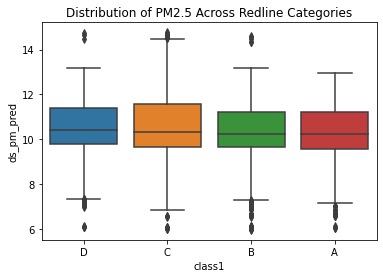

In [ ]:
#boxplot where class 1 represents the four different neighborhood grades by their pm2.5 pollutant concentration averages
sns.boxplot(data=final_df, y='ds_pm_pred', x='class1').set(title='Distribution of PM2.5 Across Redline Categories');

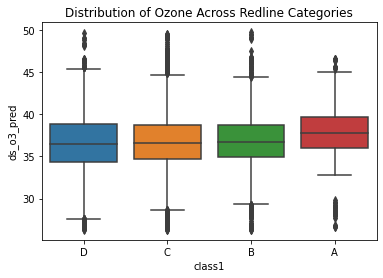

In [ ]:
sns.boxplot(data=final_df, y='ds_o3_pred', x='class1').set(title='Distribution of Ozone Across Redline Categories');

Text(0.5, 1.0, 'Mean o3 Concentration vs. Mean pm Concentration in Areas A and B')

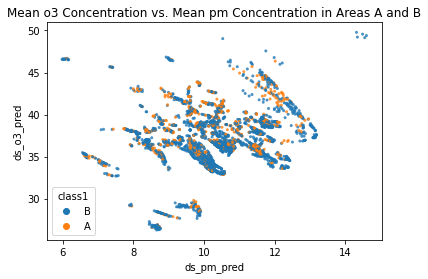

In [ ]:
#This is a scatterplot comparing the ozone and pm2.5 concentrations for 
#neighborhoods with grade A and grade B
filter = (final_df['class1']=='A') | (final_df['class1']=='B')
sns.scatterplot(data = final_df[filter], x = "ds_pm_pred", y = "ds_o3_pred", 
               hue = 'class1', edgecolor = 'none', s = 9, alpha = 0.8)
plt.title('Mean o3 Concentration vs. Mean pm Concentration in Areas A and B')

Text(0.5, 1.0, 'Mean o3 Concentration vs. Mean pm Concentration in Areas C and D')

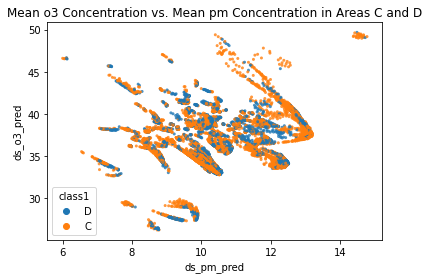

In [ ]:
#This is a scatterplot comparing the ozone and pm2.5 concentrations for 
#neighborhoods with grade C and grade D
filter = (final_df['class1']=='C') | (final_df['class1']=='D')
sns.scatterplot(data = final_df[filter], x = "ds_pm_pred", y = "ds_o3_pred", 
               hue = 'class1', edgecolor = 'none', s = 9, alpha = 0.8)
plt.title('Mean o3 Concentration vs. Mean pm Concentration in Areas C and D')

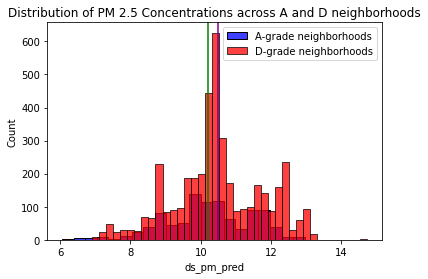

In [ ]:
#This is a an overlaid histogram depicting the distribution of PM 2.5 concentration levels 
#between A and D grade neighborhoods. However, there isn’t a big difference in the distributions as we had expected and the mean 
#PM 2.5 levels of each neighborhood are almost identical.
A_frame = final_df.loc[final_df['class1'] == 'A']
D_frame = final_df.loc[final_df['class1'] == 'D']

sns.histplot(data=A_frame, x="ds_pm_pred", color="blue", label="A-grade neighborhoods", kde=False)
sns.histplot(data=D_frame, x="ds_pm_pred", color="red", label="D-grade neighborhoods", kde=False)
plt.axvline(x= A_frame['ds_pm_pred'].mean(), color='green')
plt.axvline(x= D_frame['ds_pm_pred'].mean(), color='purple')


plt.legend() 
plt.title("Distribution of PM 2.5 Concentrations across A and D neighborhoods")
plt.show()

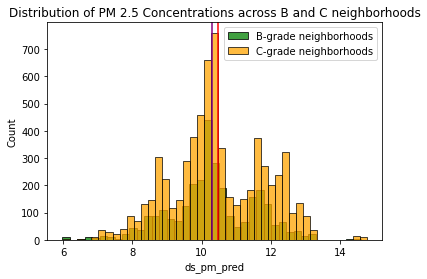

In [ ]:
#This is a an overlaid histogram depicting the distribution of PM 2.5 
#concentration levels between B and C grade neighborhoods. 
#The mean PM 2.5 levels of each neighborhood are almost identical.
B_frame = final_df.loc[final_df['class1'] == 'B']
C_frame = final_df.loc[final_df['class1'] == 'C']

sns.histplot(data=B_frame, x="ds_pm_pred", color="green", label="B-grade neighborhoods", kde=False)
sns.histplot(data=C_frame, x="ds_pm_pred", color="orange", label="C-grade neighborhoods", kde=False)
plt.axvline(x= B_frame['ds_pm_pred'].mean(), color='purple')
plt.axvline(x= C_frame['ds_pm_pred'].mean(), color='red')

plt.legend() 
plt.title("Distribution of PM 2.5 Concentrations across B and C neighborhoods")
plt.show()

## Section 2: Modeling

### Section 2.1, Technique 1: Multiple Hypothesis Testing and Decision-Making

In [ ]:
#random seed
#these three functions form the steps for an A/B test

#this function gets the difference in mean ozone or pm2.5 concentration between the specified class and members not in the specified class
def avg_diff_means(df, class1, ozone_pm25_col):
    df1 = df[[class1, ozone_pm25_col]]
    df2 = df1.groupby(class1).mean()
    difference = df2[ozone_pm25_col][1] - df2[ozone_pm25_col][0]
    return difference

#this function shuffles the binary class labels and then computes the average difference in means with the new grouping post-shuffling
def sample_once(df, class1, ozone_pm25_col):
    shuffled = df[class1].sample(n = len(df[class1]), replace = False).values
    df['shuffled'] = shuffled
    return avg_diff_means(df, 'shuffled', ozone_pm25_col)

#this function repeats the shuffling process to get the difference 10000 times and then computes the p-value
def sampling_procedure(df, class1, ozone_pm25_col):
    obs_diff = avg_diff_means(df, class1, ozone_pm25_col)
    
    differences = []
    reps = 10000
    
    for i in range(reps):
        one_test_diff = sample_once(df, class1, ozone_pm25_col)
        differences.append(one_test_diff)
    
    count = sum(differences <= obs_diff)
    return count/reps

In [ ]:
#add 4 binary columns to indicate group memberships to separate the dataframe by class label
final_df['A'] = final_df['class1'] == 'A'
final_df['B'] = final_df['class1'] == 'B'
final_df['C'] = final_df['class1'] == 'C'
final_df['D'] = final_df['class1'] == 'D'
final_df.head()

,ctfips,ds_pm_pred,ds_pm_stdd,class1,class1_lbl,class2,class2_lbl,class2_red,class3,class3_lbl,...,area_B,area_C,area_D,ds_o3_pred,ds_o3_stdd,affluent,A,B,C,D
0,1073000100,11.898241,4.332809,D,Mainly D,D-C,"Mainly D, some C","Mainly D, some C",D-C-B,"Mainly D, some C, some B",...,4.261454,26.091936,42.940308,39.039415,4.259071,0,False,False,False,True
1,1073000300,12.040417,4.320224,D,Mainly D,D-C,"Mainly D, some C","Mainly D, some C",D-C,"Mainly D, some C",...,0.000000,0.586387,93.496819,38.829519,4.186385,0,False,False,False,True
2,1073000400,12.044875,4.317920,D,Mainly D,D-C,"Mainly D, some C","Mainly D, some C",D-C,"Mainly D, some C",...,0.000000,10.454468,36.132439,38.877846,4.145246,0,False,False,False,True
3,1073000500,12.103510,4.314429,D,Mainly D,D,Mainly D,Only D,D,Mainly D,...,0.000000,0.000000,65.387039,38.752318,4.133409,0,False,False,False,True
4,1073000700,12.133744,4.283445,D,Mainly D,D,Mainly D,Only D,D,Mainly D,...,0.000000,0.000000,41.288933,38.698619,4.073281,0,False,False,False,True


In [ ]:
#test 1 conducts an A/B test for group A and the ozone concentration level, testing null hypothesis 1
#gets a p-value
a_o3 = sampling_procedure(final_df, 'A', 'ds_o3_pred')
a_o3

1.0

In [ ]:
#test 2 conducts an A/B test for group B and the ozone concentration level, testing null hypothesis 2
#gets a p-value
b_o3 = sampling_procedure(final_df, 'B', 'ds_o3_pred')
b_o3

0.9407

In [ ]:
#test 3 conducts an A/B test for group C and the ozone concentration level, testing null hypothesis 3
#gets a p-value
c_o3 = sampling_procedure(final_df, 'C', 'ds_o3_pred')
c_o3

0.1265

In [ ]:
#test 4 conducts an A/B test for group D and the ozone concentration level, testing null hypothesis 4
#gets a p-value
d_o3 = sampling_procedure(final_df, 'D', 'ds_o3_pred')
d_o3

0.0

In [ ]:
#test 5 conducts an A/B test for group A and the pm2.5 concentration level, testing null hypothesis 5
#gets a p-value
a_pm = sampling_procedure(final_df, 'A', 'ds_pm_pred')
a_pm

0.0

In [ ]:
#test 6 conducts an A/B test for group B and the pm2.5 concentration level, testing null hypothesis 6
#gets a p-value
b_pm = sampling_procedure(final_df, 'B', 'ds_pm_pred')
b_pm

0.0

In [ ]:
#test 7 conducts an A/B test for group C and the pm2.5 concentration level, testing null hypothesis 7
#gets a p-value
c_pm = sampling_procedure(final_df, 'C', 'ds_pm_pred')
c_pm

1.0

In [ ]:
#test 8 conducts an A/B test for group D and the pm2.5 concentration level, testing null hypothesis 8
#gets a p-value
d_pm = sampling_procedure(final_df, 'D', 'ds_pm_pred')
d_pm

0.9998

In [ ]:
#code for Bonferroni correction procedure that controls for FWER by using a new alpha which is 0.05/8
#looks at whether all p-values from all 8 tests above are less-than or equal to new alpha
#reject null for that respective test if so
new_a = 0.05/8

p_vals = [a_o3, b_o3, c_o3, d_o3, a_pm, b_pm, c_pm, d_pm]

decisions = [p_vals[i] <= new_a for i in range(len(p_vals))]
decisions

[False, False, False, True, True, True, False, False]

In [ ]:
#code for BH Procedure that controls FDP by computing a new threshold for each test based on its index
#uses the formula for line (index) * (p-value/8)
#get highest p-value below the line
#use this as threshold for all tests
#looks at whether all p-values from all 8 tests above are less-than or equal to new threshold
#reject null for that respective test if so
p_vals = [a_o3, b_o3, c_o3, d_o3, a_pm, b_pm, c_pm, d_pm]
sorted_p_vals = sorted(p_vals)

highest = -100

for i in range(len(sorted_p_vals)):
    if sorted_p_vals[i] <= (i+1)*(0.05/len(sorted_p_vals)):
        highest = sorted_p_vals[i]

print("new threshold:", highest)
print(p_vals)

decisions_bh = p_vals <= highest
decisions_bh

new threshold: 0.0
[1.0, 0.9407, 0.1265, 0.0, 0.0, 0.0, 1.0, 0.9998]


array([False, False, False,  True,  True,  True, False, False])

In [ ]:
#supplementary dataframe to create the graph in next cell
#add all p-values from 8 tests
#add all sorted p-values from 8 tests
#add all bonferroni threshold values
#add all bh procedure threshold values
frame = pd.DataFrame(p_vals)
frame['index'] = np.arange(1, 9)
frame['p_vals'] = p_vals
frame['sorted'] = sorted_p_vals
frame['bonferroni'] = [0.05/8] * 8
frame['bh'] = frame['index']*(0.05/8)
frame

,0,index,p_vals,sorted,bonferroni,bh
0,1.0000,1,1.0000,0.0000,0.00625,0.00625
1,0.9407,2,0.9407,0.0000,0.00625,0.01250
2,0.1265,3,0.1265,0.0000,0.00625,0.01875
3,0.0000,4,0.0000,0.1265,0.00625,0.02500
4,0.0000,5,0.0000,0.9407,0.00625,0.03125
5,0.0000,6,0.0000,0.9998,0.00625,0.03750
6,1.0000,7,1.0000,1.0000,0.00625,0.04375
7,0.9998,8,0.9998,1.0000,0.00625,0.05000


Text(0.5, 0, 'index')

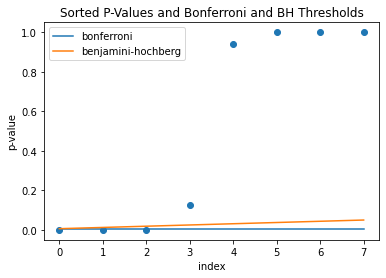

In [ ]:
#plot sorted p-values from 8 tests
#plot computed bonferroni threshold and bh threshold line
plt.scatter(x = frame.index, y = frame['sorted'])
plt.plot(frame['bonferroni'], label = 'bonferroni')
plt.plot(frame['bh'], label = 'benjamini-hochberg')
plt.legend()
plt.title('Sorted P-Values and Bonferroni and BH Thresholds')
plt.ylabel('p-value')
plt.xlabel('index')

### Section 2.2, Technique 2: GLMs and Prediction

#### Nonparametric Methods

Feature creation on ozone and pm2.5 concentrations to aid in higher accuracy for nonparametric models. 

In [ ]:
#creating new feature high_pm which is 1 if the pm2.5 polluntant concentration raises above 12, which is considered to be above normal 
final_df['high_pm'] = (final_df['ds_pm_pred']>12).astype(int)
#creating a linear combination of ozone and pm2.5 concentration predictions by multiplying the two prediction averages together 
final_df['feature1'] = final_df['ds_pm_pred']*final_df['ds_o3_pred']
#creating a linear combination of ozone and pm2.5 concentration standard deviations by multiplying 
final_df['feature2'] = final_df['ds_pm_stdd']*final_df['ds_o3_stdd']
#creating a linear combination of pm2.5 concentrations by multiplying pollutant standard deviation and concentration values 
final_df['feature3'] = final_df['ds_pm_stdd']*final_df['ds_pm_pred']
#creating a linear combination of ozone concentrations by multiplying ozone standard deviation and concentration values
final_df['feature4'] = final_df['ds_o3_pred']*final_df['ds_o3_stdd']

Spliting up 50% of the data into a train set and 50% into a test set

In [ ]:
#using sklearn train test split package to randomly split the data with a test size of 50%
X_train, X_test, y_train, y_test = train_test_split(final_df[['ds_pm_pred','ds_pm_stdd','ds_o3_pred','ds_o3_stdd',
                                                           'high_pm','feature1','feature2','feature3','feature4']], 
                                                    final_df['affluent'], test_size=0.5, random_state=42)

Training a random forest classifier on the training set of the data and predicting affluent values for the test set. Finally, getting the accuracy of the predictions

In [ ]:
#initializing random forset classifier from sklearn package, with max_depth 200 and max_features = 3 which is 1/3 of the total features
rfc = RandomForestClassifier(max_depth=200, random_state=42,max_features=3) 
#fit the random forest classifier to train data
rfc.fit(X_train,y_train)
#getting accuracy for predictions made by the random forest classifier on whether or not the grade level for a neighborhood based on concentrations is 'A','B' or 'C','D'
print('Accuracy: ') 
print(rfc.score(X_test, y_test))

Accuracy: 
0.8048319611283574


In [ ]:
#initializing neural network from sklearn package with (10, 10) hidden layers
clf = MLPClassifier(hidden_layer_sizes = (10,10), random_state = 42) 
#fit the sklearn's Multi-layer Perceptron classifier to train data
clf.fit(X_train, y_train)
#getting accuracy for predictions made by the neural network on whether or not the grade level for a neighborhood based on concentrations is 'A','B' or 'C','D'
print('Accuracy: ') 
print(clf.score(X_test, y_test))

Accuracy: 
0.7315427183155622


#### GLMs

**Frequentist**

Code for a fequentist GLM logistic model to predict affluent neighborhoods based on ozone predictions 



In [ ]:
#initializing logistic GLM and adding ozone as a constant to predict 0/1 binary feature affluent using a binomial family
logistic_model = sm.GLM(
    final_df.affluent, sm.add_constant(final_df.ds_o3_pred), 
    family=sm.families.Binomial()
)
#fitting the model and printing logistic results summary 
logistic_results = logistic_model.fit()
print(logistic_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               affluent   No. Observations:                14818
Model:                            GLM   Df Residuals:                    14816
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8548.1
Date:                Mon, 12 Dec 2022   Deviance:                       17096.
Time:                        18:43:20   Pearson chi2:                 1.48e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4622      0.213    -11.543      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Code for a fequentist GLM logistic model to predict affluent neighborhoods based on pm2.5 concentration predictions 


In [ ]:
#initializing logistic GLM and adding pm2.5 pollutant as a constant to predict 0/1 binary feature affluent using a binomial family
logistic_model = sm.GLM(
    final_df.affluent, sm.add_constant(final_df.ds_pm_pred), 
    family=sm.families.Binomial()
)
#fitting the model and printing logistic results summary
logistic_results = logistic_model.fit()
print(logistic_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               affluent   No. Observations:                14818
Model:                            GLM   Df Residuals:                    14816
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8538.2
Date:                Mon, 12 Dec 2022   Deviance:                       17076.
Time:                        18:43:21   Pearson chi2:                 1.48e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1884      0.149      1.264      0.2

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Defining a funcition to create bootstrap samples of the estimates

In [ ]:
def bootstrap_xy(X, y, fnc, original_estimate=None, B=1000, plot=True):
    """
    Uses bootstrap to generate multiple samples for estimates
    of the provided function.
    """
    d = X.shape[1]
    N = X.shape[0]
    w_hat = fnc(X, y)
    w_boot = np.zeros(shape=(B,d))
    for b in range(B):
        # we need to choose x-y pairs, so start by picking indices
        bootstrap_indices = np.random.choice(np.arange(N), N)
        # then, use those indices to create a bootstrap sample
        bootstrap_X = X.iloc[bootstrap_indices, :]
        bootstrap_y = y.iloc[bootstrap_indices]
        w_boot[b,:] = fnc(bootstrap_X, bootstrap_y)
    if plot:
        plt.scatter(w_boot[:,0], w_boot[:,1], c='b')
        plt.scatter(w_hat[0], w_hat[1], c='r', marker='x', s=300)
        if original_estimate:
            plt.scatter(*original_estimate, c='g', marker='x', s=300)
    return w_boot

Defining a function to aid with the bootstrap_xy funtion and create comparable estimates using a binomial model, to keep it consistent with the GLM family

In [ ]:
def binom_model(x, y): 
    model = sm.GLM(
        y, x,
        family=sm.families.Binomial()
    )
    results = model.fit()
    #extracting beta for intercept and x val parameters for bootstrap
    params = results.params
    
    return params


Running bootstrap code for pm2.5 pollutant concentrations with a binomial model 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Text(0.5, 1.0, 'Logistic regression')

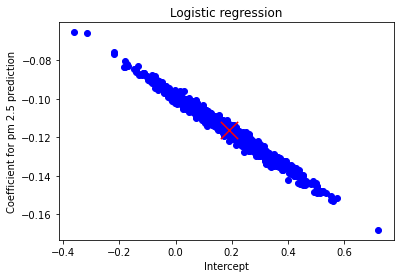

In [ ]:
#plugging in constant as pm2.5 pollutant concentration, and affluent as the predictor, with function as binomial model - mimic GLM from above
w_binom_boot_pm = bootstrap_xy(sm.add_constant(final_df.ds_pm_pred), final_df.affluent, binom_model)
#plot bootstrapped values of intercept to quantify possible uncertainty
plt.xlabel('Intercept')
plt.ylabel('Coefficient for pm 2.5 prediction')
plt.title('Logistic regression')

Running bootstrap code for ozone concentrations with a binomial model 

Text(0.5, 1.0, 'Logistic regression')

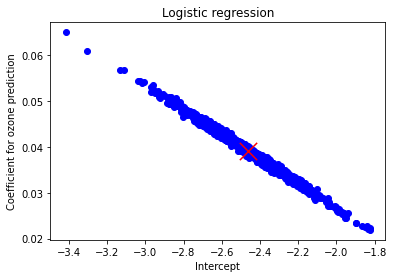

In [ ]:
#plugging in constant as ozone concentration, and affluent as the predictor, with function as binomial model - mimic GLM from above
w_binom_boot_o3 = bootstrap_xy(sm.add_constant(final_df.ds_o3_pred), final_df.affluent, binom_model)
#plot bootstrapped values of intercept to quantify possible uncertainty
plt.xlabel('Intercept')
plt.ylabel('Coefficient for ozone prediction')
plt.title('Logistic regression')

Printing out beta (coefficient values) for intercept and pm2.5 concentrations for affluent predictors through bootstrap samples standard deviation (to extract standard error)

In [ ]:
#beta 0 represents intercept, beta 1 represents pm2.5
beta_0, beta_1 = w_binom_boot_pm.std(axis = 0)
print(f"Bootstrap std error for intercept: {beta_0:.3f}")
print(f"Bootstrap std error for pm2.5 coeff: {beta_1:.3f}")

Bootstrap std error for intercept: 0.141
Bootstrap std error for pm2.5 coeff: 0.013


Printing out beta (coefficient values) for intercept and ozone concentrations for affluent predictors through bootstrap samples standard deviation (to extract standard error)

In [ ]:
#beta 0 represents intercept, beta 1 represents ozone
beta_0, beta_1 = w_binom_boot_o3.std(axis = 0)
print(f"Bootstrap std error for intercept: {beta_0:.3f}")
print(f"Bootstrap std error for ozone coeff: {beta_1:.3f}")

Bootstrap std error for intercept: 0.219
Bootstrap std error for ozone coeff: 0.006


**Bayesian**

In [ ]:
#response variable y is whether a neighborhood is "affluent" or not
y_simple = final_df['affluent']
#response variable x is PM2.5 concentration
x_0 = final_df['ds_pm_pred'].values
x_c = x_0 - x_0.mean()

#simple model to conduct posterior predictive check
with pm.Model() as model_simple:
  #prior - α and β have normal distribution
    α = pm.Normal('α', mu = 0, sd = 10)
    β = pm.Normal('β', mu = 0, sd = 10)
    
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    
    y_1 = pm.Bernoulli('y_1', p = θ, observed = y_simple)

    trace_simple = pm.sample(1000, tune = 1000, cores=-1)

/usr/local/lib/python3.8/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


In [ ]:
#summary of variables α and β for the simple Bayesian GLM
import arviz as az
az.summary(trace_simple, var_names=['α', 'β'])

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-1.025,0.019,-1.060,-0.992,0.0,0.0,1622.0,1342.0,1.0
β,-0.116,0.015,-0.141,-0.088,0.0,0.0,1989.0,1464.0,1.0


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

#posterior predictive check for simple model
ppc = pm.sample_posterior_predictive(trace_simple, model = model_simple, samples = 500)
preds = np.rint(ppc['y_1'].mean(axis = 0)).astype('int')
print('Accuracy of the logistic model:', accuracy_score(preds, final_df['affluent']))

/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Accuracy of the logistic model: 0.734782021865299


In [ ]:
#advanced Bayesian GLM
with pm.Model() as logistic_model:
    # specify glm and pass in data
    pm.glm.GLM.from_formula("affluent ~ ds_pm_pred + ds_o3_pred", final_df, family=pm.glm.families.Binomial())
    # draw posterior samples using NUTS sampling
    trace = pm.sample(1000, tune=1000, init="adapt_diag",cores=-1)

We recommend to instead use Bambi https://bambinos.github.io/bambi/
/usr/local/lib/python3.8/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


In [ ]:
#function to plot intercepts as well as uncertainty of each of these values 
def plot_traces(traces, model, retain=0):
    """
    Convenience function:
    Plot traces with overlaid means and values
    """
    with model:
        ax = az.plot_trace(
            traces[-retain:],
            lines=tuple([(k, {}, v["mean"]) for k, v in az.summary(traces[-retain:]).iterrows()]),
        )

        for i, mn in enumerate(az.summary(traces[-retain:])["mean"]):
            ax[i, 0].annotate(
                f"{mn:.2f}",
                xy=(mn, 0),
                xycoords="data",
                xytext=(15, 10),
                textcoords="offset points",
                rotation=90,
                va="bottom",
                fontsize="large",
                color="#AA0022",
            )

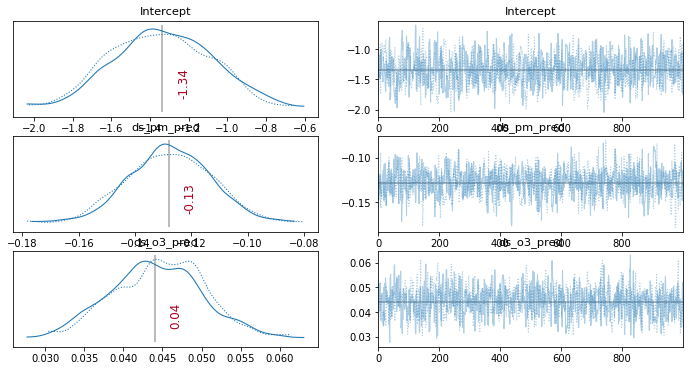

In [ ]:
plot_traces(trace, logistic_model);

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 648x504 with 0 Axes>

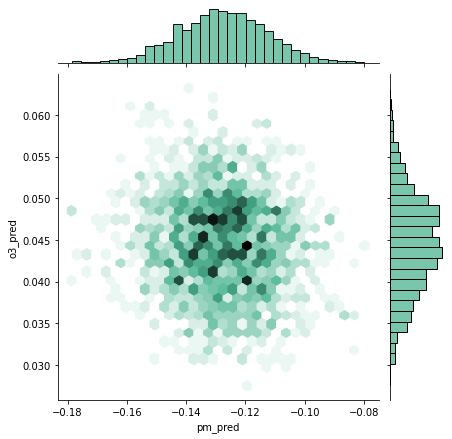

In [ ]:
#hexplot of PM2.5 concentrations and Ozone concentrations across all neighborhood grades
plt.figure(figsize=(9, 7))
sns.jointplot(trace["ds_pm_pred"], trace["ds_o3_pred"], kind="hex", color="#4CB391")
plt.xlabel("pm_pred")
plt.ylabel("o3_pred");

In [ ]:
#summary of intercepts and coefficients of the advanced Bayesiam GLM
pm.summary(trace)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.337,0.251,-1.806,-0.888,0.009,0.007,740.0,745.0,1.00
ds_pm_pred,-0.128,0.015,-0.155,-0.100,0.001,0.000,846.0,842.0,1.00
ds_o3_pred,0.044,0.006,0.034,0.055,0.000,0.000,784.0,867.0,1.01


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

#posterior predictive check for advanced model
ppc = pm.sample_posterior_predictive(trace, model = logistic_model, samples = 500)
preds = np.rint(ppc['y'].mean(axis = 0)).astype('int')
print('Accuracy of the logistic model:', accuracy_score(preds, final_df['affluent']))

/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Accuracy of the logistic model: 0.734916992846538
